# Dataset

In [ ]:
!pip install networkx==2.6

In [ ]:
!gdown 1iVPWjOmwzx0ktyUEmxG8kIYApKcaoQK7

Downloading...
From: https://drive.google.com/uc?id=1iVPWjOmwzx0ktyUEmxG8kIYApKcaoQK7
To: /content/fakenews_k=3_fold=0.gpickle
100% 5.41M/5.41M [00:00<00:00, 201MB/s]


In [ ]:
import networkx as nx

G = nx.read_gpickle('fakenews_k=3_fold=0.gpickle')

In [ ]:
G.nodes

In [ ]:
G.edges

In [ ]:
G.nodes[0]['features'][:10]

array([-0.02726702, -0.05425571,  0.03504298, -0.03019014,  0.02330367,
       -0.04408935,  0.0527001 , -0.03046613,  0.05018904,  0.02013915],
      dtype=float32)

In [ ]:
G.nodes[0]['label']

1

In [ ]:
from plotly import graph_objs as go

def show_graph(G):
  ### ARESTAS
  edge_x = []
  edge_y = []

  # adicionando as coordenadas
  for edge in G.edges():
      x0, y0 = G.nodes[edge[0]]['pos']
      x1, y1 = G.nodes[edge[1]]['pos']
      edge_x.append(x0)
      edge_x.append(x1)
      edge_x.append(None)
      edge_y.append(y0)
      edge_y.append(y1)
      edge_y.append(None)

  # definindo cor e estilo das arestas
  edge_trace = go.Scatter(
      x=edge_x, y=edge_y,
      line=dict(width=2, color='#888'),
      hoverinfo='none',
      mode='lines')

  ### VÉRTICES
  node_x = []
  node_y = []

  # adicionando as coordenadas
  for node in G.nodes():
      x, y = G.nodes[node]['pos']
      node_x.append(x)
      node_y.append(y)

  # definindo cor e estilo dos vértices
  node_trace = go.Scatter(
      x=node_x, y=node_y,
      mode='markers',
      hoverinfo='text',
      marker=dict(
          size=10,
          line_width=2))


  node_labels = []
  for node in G.nodes():
    node_labels.append(G.nodes[node]['label'])

  node_trace.marker.color = node_labels

  # visualizando!
  fig = go.Figure(data=[edge_trace, node_trace],
              layout=go.Layout(
                  showlegend=False,
                  hovermode='closest',
                  margin=dict(b=20,l=5,r=5,t=40),
                  xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                  yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
                  )
  fig.show()

In [ ]:
pos = nx.spring_layout(G,seed=42) # obtém coordenadas dos vértices para visualização
for node in G.nodes():
  G.nodes[node]['pos'] = pos[node]

In [ ]:
show_graph(G)

# Graph Autoencoder

In [ ]:
!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-2.1.0%2Bcu118.html

In [ ]:
import random
import numpy as np

## Definindo nossa GNN

In [ ]:
from torch_geometric.nn import GCNConv
import torch

class GCNEncoder(torch.nn.Module):
  def __init__(self, in_channels, out_channels):
    super().__init__()
    self.conv1 = GCNConv(in_channels, 2 * out_channels)
    self.conv2 = GCNConv(2 * out_channels, out_channels)
  def forward(self, X, A):
    x1 = self.conv1(X, A).relu()
    x2 = self.conv2(x1, A)
    return x2

def train(gae, optimizer, graph):

  gae.train()
  optimizer.zero_grad()

  H_L = gae.encode(graph.features.float(), graph.edge_index)

  loss = gae.recon_loss(H_L, graph.edge_index)

  loss.backward()
  optimizer.step()

  return float(loss), H_L

## Exexutando treinando da GNN

In [ ]:
import torch_geometric.utils as utils
from torch_geometric.nn import GAE

random.seed(81)
np.random.seed(81)
torch.manual_seed(81)
torch.cuda.manual_seed(81)

device = torch.device('cuda')

dataset = utils.from_networkx(G)

in_channels, out_channels = len(dataset.features[0]), 2

gae = GAE(GCNEncoder(in_channels, out_channels))

gae = gae.to(device)
gae = gae.float()

dataset = dataset.to(device)

optimizer = torch.optim.Adam(gae.parameters(), lr = 0.01)

epochs = 12

losses = []
embs_list = []

for epoch in range(epochs):
  loss, H_L = train(gae, optimizer, dataset)
  losses.append(loss)
  embs_list.append(H_L)

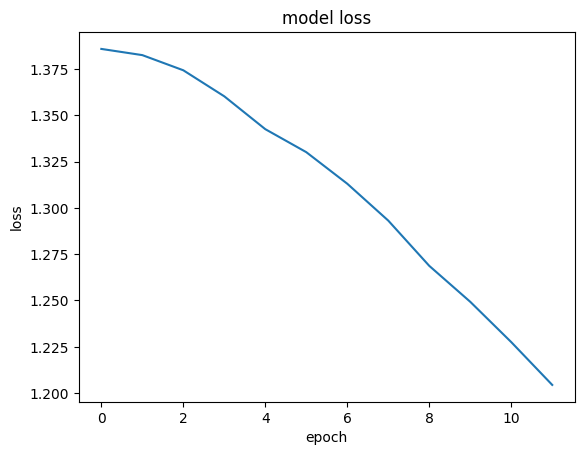

In [ ]:
import matplotlib.pyplot as plt

plt.plot(losses)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

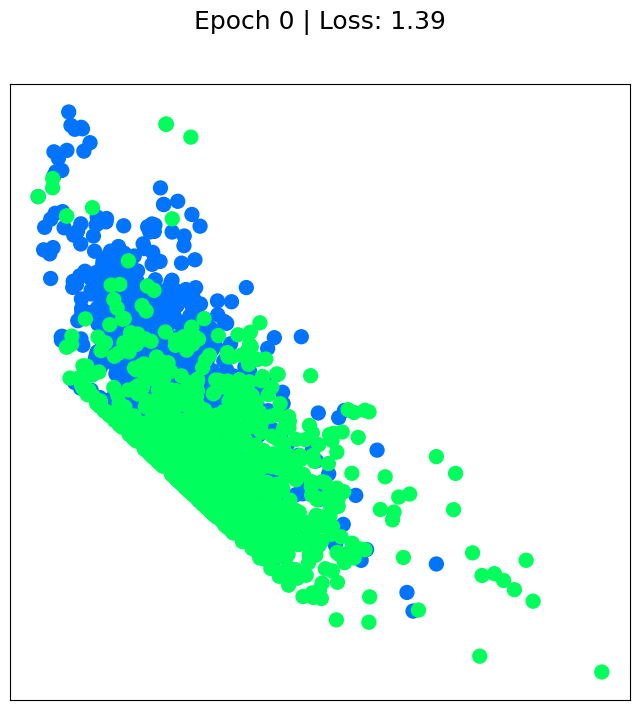

In [ ]:
from IPython.display import HTML
from matplotlib import animation

labels_plot = np.array([G.nodes[node]['label'] for node in G.nodes])

def animate(i):
    embed = embs_list[i].detach().cpu().numpy()
    ax.clear()
    ax.scatter(embed[:, 0], embed[:, 1], s=100, c=labels_plot, cmap="hsv", vmin=-2, vmax=3)
    plt.title(f'Epoch {i} | Loss: {losses[i]:.2f}', fontsize=18, pad=40)

fig = plt.figure(figsize=(8, 8))

plt.axis('off')
ax = fig.add_subplot()
plt.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)

anim = animation.FuncAnimation(fig, animate, np.arange(0, epochs, 1), interval=800, repeat=True)
html = HTML(anim.to_html5_video())

In [ ]:
display(html)

## Obtendo representações da GNN

In [ ]:
with torch.no_grad():
  embs = gae.encode(dataset.features.float(), dataset.edge_index)

In [ ]:
for node in G.nodes():
  G.nodes[node]['features_gae'] = embs[node].cpu().numpy()

In [ ]:
G.nodes[0]['features_gae']

array([0.45810968, 0.3499955 ], dtype=float32)

## Separando nossas noticias para avaliar

In [60]:
x_int = []
x_out = []

for node in G.nodes():
  if G.nodes[node]['label'] == 1:
    x_int.append(G.nodes[node]['features_gae'])
  else:
    x_out.append(G.nodes[node]['features_gae'])

In [61]:
from sklearn.model_selection import train_test_split

x_train, x_test = train_test_split(x_int, test_size=0.1, random_state=81) # separando em treino e teste

# One-Class Learning

In [62]:
from sklearn.metrics import classification_report
from sklearn.svm import OneClassSVM as OCSVM

ocsvm = OCSVM(kernel='rbf', nu=0.2) # criando algoritmo

ocsvm.fit(x_train) # treinando algoritmo

y_int_pred = ocsvm.predict(x_test) # predizendo novos exemplos
y_out_pred = ocsvm.predict(x_out) # predizendo novos exemplos

y_true = np.concatenate([[1] * len(x_test), [-1] * len(x_out)])
y_pred = np.concatenate([y_int_pred, y_out_pred])

print(classification_report(y_true, y_pred)) # avaliando

              precision    recall  f1-score   support

          -1       0.99      0.97      0.98      1020
           1       0.76      0.90      0.83       105

    accuracy                           0.96      1125
   macro avg       0.88      0.94      0.90      1125
weighted avg       0.97      0.96      0.97      1125



# Vizualização


## Função de decisão


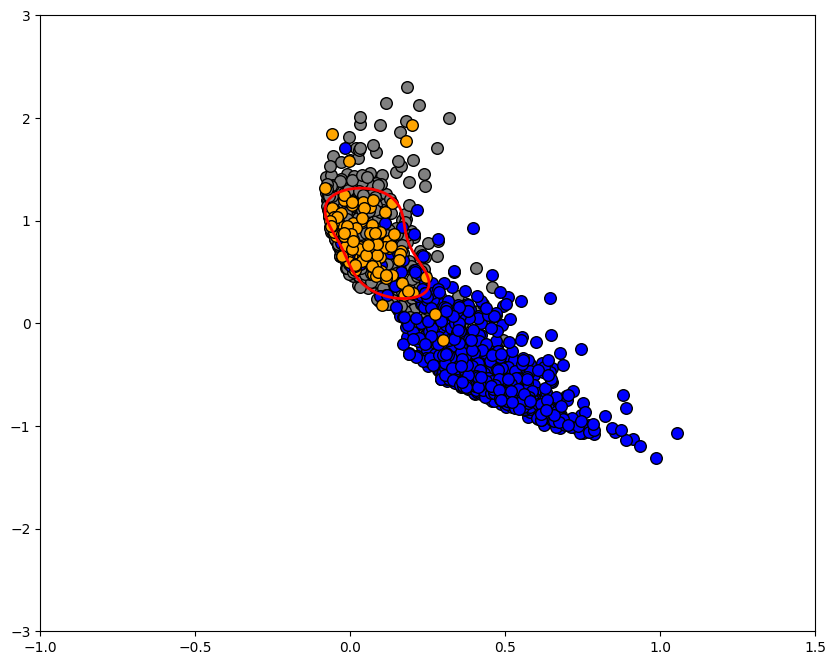

In [63]:
fig = plt.figure(figsize=(10, 8))

plt.scatter(np.array(x_train)[:, 0], np.array(x_train)[:, 1], c='gray', s=70, edgecolors='k') #treino

plt.scatter(np.array(x_out)[:, 0], np.array(x_out)[:, 1], c='blue', s=70, edgecolors='k')

plt.scatter(np.array(x_test)[:, 0], np.array(x_test)[:, 1], c='orange', s=70, edgecolors='k') #teste interesse

xx, yy = np.meshgrid(np.linspace(-3, 3, 500), np.linspace(-3, 3, 500))

Z = ocsvm.decision_function(np.c_[xx.ravel(), yy.ravel()])

Z = Z.reshape(xx.shape)

plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='red') #esfera

plt.xlim((-1, 1.5))
plt.ylim((-3, 3))
plt.show()

## Modelage em grafo com embeddings na posição

In [ ]:
for node in G.nodes():
  G.nodes[node]['pos'] = G.nodes[node]['features_gae']

In [ ]:
show_graph(G)